# Regression Demo - Neural Network

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
from distrax._src.distributions.categorical import Categorical
from distrax._src.distributions.mixture_same_family import MixtureSameFamily
from distrax._src.distributions.bernoulli import Bernoulli
from distrax._src.distributions.uniform import Uniform
from distrax._src.distributions.normal import Normal
from tensorflow_probability.substrates import jax as tfp


tfd = tfp.distributions
logits = jnp.array([0.33, 0.33, 0.33])
probs = jax.nn.softmax(logits, axis=-1)
x_cat_dist = Categorical(probs=probs)
norm_dist = Normal(loc=[-4.0, 0.0, 4.0], scale=[0.4, 0.6, 0.4])
mix_dist = MixtureSameFamily(x_cat_dist, norm_dist)


def synthetic_mixture(n_samples: int = 1_000, X=None):
    if X is None:
        logits = jnp.array([1.0, 1.0, 1.0])
        probs = jax.nn.softmax(logits, axis=-1)
        x_cat_dist = Categorical(probs=probs)
        norm_dist = Normal(loc=[-4.0, 0.0, 4.0], scale=[0.7, 0.6, 0.7])
        mix_dist = MixtureSameFamily(x_cat_dist, norm_dist)
        X_samples = mix_dist.sample(seed=123, sample_shape=(n_samples,))[:, None]
    else:
        X_samples = X
    loc = np.sin(X_samples.ravel())
    scale = np.exp(np.cos(X_samples.ravel()))
    Y = np.random.normal(loc, scale)[:, None]
    return X_samples, Y


def synthetic_bowtie(n_samples: int = 1_000, X=None):
    if X is None:
        X = jnp.linspace(0, 4 * jnp.pi, n_samples)[:, None]
    loc = np.sin(X.ravel())
    scale = np.exp(np.cos(X.ravel()))
    Y = np.random.normal(loc, scale)[:, None]
    return X, Y

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn import datasets
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(
    n_samples: int, batch_size: int, seed: int, noise: float = 0.05,
) -> Iterator[Batch]:
    # make random normally distributed data
    rng = np.random.RandomState(seed)
    X, Y = synthetic_mixture(n_samples)
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [5]:
# train/valid dataset loaders
# wandb_logger.config.batch_size = 128
n_init_samples = 1_000
n_train = 1_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123)

# demo batch
init_X, init_Y = next(init_ds)
init_X.shape, init_Y.shape

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


((1000, 1), (1000, 1))

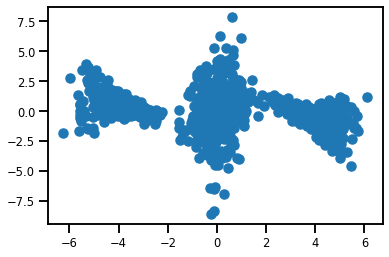

In [6]:
fig, ax = plt.subplots()

ax.scatter(init_X, init_Y)
plt.show()

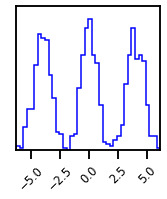

In [7]:
# plot data
fig = corner.corner(init_X, color="blue", hist_bin_factor=2)

## DataLoader

In [8]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch) -> Array:
    inputs, labels = batch

    # select image from tfds
    inputs = inputs.astype(jnp.float32)
    labels = labels.astype(jnp.float32)

    # make 1D
    #     labels = jnp.expand_dims(labels, axis=-1)

    return inputs, labels

### Init Data

In [9]:
# initialization data
n_init_samples = 1_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123)
# demo batch
init_ds = next(init_ds)
X_init, Y_init = prepare_data(init_ds)
X_init, Y_init = np.array(X_init), np.array(Y_init)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


## Simple Model

In [11]:
from distrax._src.distributions.log_stddev_normal import LogStddevNormal
from typing import Sequence, Callable, Tuple
import flax
from flax import linen as nn
from flax import struct


class ExplicitMLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        # we automatically know what to do with lists, dicts of submodules
        self.layers = [nn.Dense(feat) for feat in self.features]
        # for single submodules, we would just write:
        # self.layer1 = nn.Dense(self, feat1)

    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.relu(x)
        return x


class ProbNet(nn.Module):
    features: Sequence[int]

    def setup(self):
        self.core_net = ExplicitMLP(features=self.features)

    def __call__(self, inputs):

        x = self.core_net(inputs)

        return x


class DualHeadProbNet(nn.Module):
    core_features: Sequence[int]
    head_features: Sequence[int]

    def setup(self):
        self.core_net = ExplicitMLP(features=self.core_features)
        self.loc_net = ExplicitMLP(features=self.head_features)
        self.std_net = ExplicitMLP(features=self.head_features)

    def __call__(self, inputs):

        x = self.core_net(inputs)

        loc_preds = self.loc_net(x)
        stds_preds = self.std_net(x)

        return jnp.concatenate([loc_preds, stds_preds], axis=1)


const = jnp.log(jnp.expm1(1.0))


@struct.dataclass
class ConditionalModel:
    params: dict
    model: Callable = struct.field(pytree_node=False)

    def forward(self, inputs) -> Tuple[Array, Array]:
        # forward pass for params
        outputs = self.model.apply(self.params, inputs)
        # split params
        split = outputs.shape[1] // 2

        # compute means and log stds
        means = outputs[..., :split]
        log_stds = outputs[..., split:]
        dist = LogStddevNormal(loc=means, log_scale=log_stds)

        return dist

In [12]:
from distrax._src.distributions.normal import Normal

# create model
input_features = X_init.shape[1]
# model = nn.Dense(features=input_features * 2)
model = ProbNet(features=[64, 64, 2])
# model = DualHeadProbNet(core_features=[64, 64], head_features=[32, 16, 1])
# create dummy variable
rng, model_rng = jax.random.split(KEY, 2)
params = model.init(model_rng, X_init)

In [13]:
# initialize conditional model
cond_model = ConditionalModel(params=params, model=model)

# forward pass
y_dist = cond_model.forward(X_init)
y_dist.mean().shape, y_dist.stddev().shape

((1000, 1), (1000, 1))

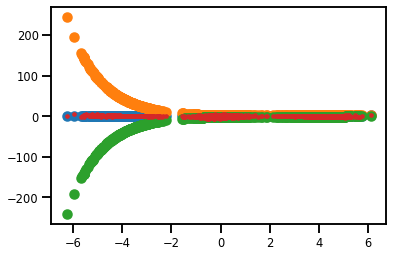

In [14]:
plt.scatter(X_init, y_dist.mean())
plt.scatter(X_init, y_dist.mean() + 1.96 * y_dist.stddev())
plt.scatter(X_init, y_dist.mean() - 1.96 * y_dist.stddev())
plt.scatter(X_init, Y_init, s=10)

#### Loss Functions

In [15]:
from chex import dataclass
from distrax._src.distributions.log_stddev_normal import LogStddevNormal


def nll_loss(y_mu, y_std, y_true):

    dist = LogStddevNormal(loc=y_mu, log_scale=y_std)

    nll = dist.log_prob(y_true).sum(axis=1)

    return -jnp.mean(nll)


def loss_fn(model, batch: Batch) -> Array:

    inputs, outputs = prepare_data(batch)

    y_dist = model.forward(inputs)

    nll = y_dist.log_prob(outputs).sum(axis=1)

    return -jnp.mean(nll, axis=0)


@jax.jit
def eval_fn(model, batch: Batch) -> Array:

    inputs, outputs = prepare_data(batch)

    y_dist = model.forward(inputs)

    nll = y_dist.log_prob(outputs).sum(axis=1)

    return -jnp.mean(nll, axis=0)

In [16]:
init_ds = load_dataset(n_init_samples, n_init_samples, 123)

nll_loss = loss_fn(cond_model, next(init_ds))
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")


nll_loss = eval_fn(cond_model, next(init_ds))
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")

Initial NLL Loss (Train): 3.2785
Initial NLL Loss (Train): 3.2785


#### Optimizer

In [17]:
from rbig_jax.training.parametric import init_optimizer

# optimizer params

eval_frequency = 50
learning_rate = 1e-3

n_epochs = 5_000
# initialize optimizer
optimizer = init_optimizer(
    "adam",
    lr=learning_rate,
    cosine_decay_steps=n_epochs,
    gradient_norm_clip=1.0,
    alpha=1e-2,
)
# intialize optimizer state
opt_state = optimizer.init(cond_model)

#### Train Step

In [18]:
from typing import Tuple, Any
import optax

OptState = Any


@jax.jit
def update(
    params: dataclass, opt_state: OptState, batch: Batch
) -> Tuple[dataclass, OptState]:
    """Single SGD update step."""
    # calculate the loss AND the gradients
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)

    # update the gradients
    updates, new_opt_state = optimizer.update(grads, opt_state)

    # update the parameters
    new_params = optax.apply_updates(params, updates)

    # return loss AND new opt_state
    return new_params, new_opt_state, loss

#### Train Lopp

In [19]:
n_train = 5_000
train_ds = load_dataset(n_train, 512, 123)
valid_ds = load_dataset(2_000, 1_000, 123 + 100)


metrics = {
    "train_step": list(),
    "train_loss": list(),
    "valid_step": list(),
    "valid_loss": list(),
}


eval_loss = 0.0

In [20]:
# %%wandb

import tqdm


with tqdm.trange(n_epochs) as pbar:
    for step in pbar:
        cond_model, opt_state, loss = update(cond_model, opt_state, next(train_ds))

        pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
        #         wandb.log({"train_loss": float(loss), "training_step": step})
        metrics["train_step"].append(step)
        metrics["train_loss"].append(loss)

        if step % eval_frequency == 0:
            eval_loss = eval_fn(cond_model, next(valid_ds))

            pbar.set_description(
                f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )
            #             wandb.log({"validation_loss": float(eval_loss), "training_step": step})
            metrics["valid_step"].append(step)
            metrics["valid_loss"].append(eval_loss)

Train Loss: 1.3504 | Valid Loss: 1.3635: 100%|██████████| 5000/5000 [00:15<00:00, 316.87it/s]


### Results

#### Losses

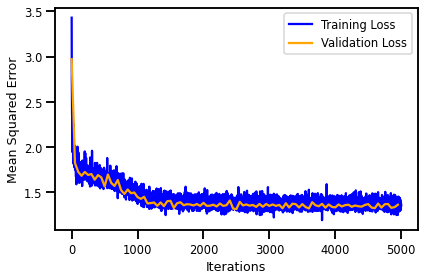

In [21]:
fig, ax = plt.subplots()
ax.plot(
    metrics["train_step"], metrics["train_loss"], label="Training Loss", color="blue"
)
ax.plot(
    metrics["valid_step"],
    metrics["valid_loss"],
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Mean Squared Error",
)
plt.legend()
plt.tight_layout()
plt.show()

#### Predictions

In [22]:
n_plot_samples = 10_000
rng = np.random.RandomState(42)
# X_plot = np.sort(rng.randn(n_plot_samples, 1))
X_plot = np.linspace(X_init.min(), X_init.max(), n_plot_samples)[:, None]

In [23]:
_, Y_plot = synthetic_mixture(None, X_plot)

In [24]:
y_dist = cond_model.forward(X_plot)

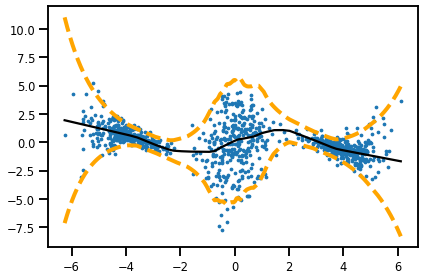

In [25]:
fig, ax = plt.subplots()
plt.plot(X_plot, y_dist.mean(), color="black")
plt.plot(
    X_plot,
    y_dist.mean() + 1.96 * y_dist.stddev(),
    color="orange",
    linestyle="--",
    linewidth=4,
)
plt.plot(
    X_plot,
    y_dist.mean() - 1.96 * y_dist.stddev(),
    color="orange",
    linestyle="--",
    linewidth=4,
)
ax.scatter(X_init, Y_init, s=5)
plt.tight_layout()
plt.show()

In [26]:
import uncertainty_toolbox.viz as uviz
import uncertainty_toolbox.metrics as umetric

In [27]:
# Compute all uncertainty metrics
metrics = umetric.get_all_metrics(
    y_dist.mean().ravel(), y_dist.stddev().ravel(), Y_plot.ravel(),
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


  0%|          | 0/10 [00:00<?, ?it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


  0%|          | 0/10 [00:00<?, ?it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.043
  RMSE          1.575
  MDAE          0.615
  MARPD         101.819
  R2            0.103
  Correlation   0.372
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.012
  Mean-absolute Calibration Error       0.010
  Miscalibration Area                   0.011
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.023
     Group Size: 0.56 -- Calibration Error: 0.015
     Group Size: 1.00 -- Calibration Error: 0.010
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.028
     Group Size: 0.56 -- Calibration Error: 0.017
     Group Size: 1.00 -- Calibration Error: 0.012
==============

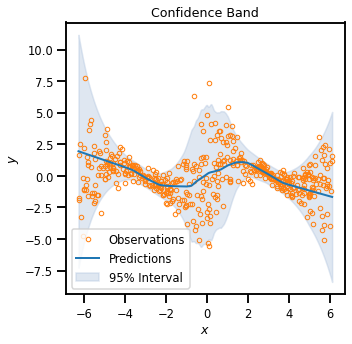

In [28]:
uviz.plot_xy(
    y_dist.mean().ravel(),
    y_dist.stddev().ravel(),
    Y_plot.ravel(),
    X_plot.ravel(),
    n_subset=500,
)
plt.savefig("probnet_pred")

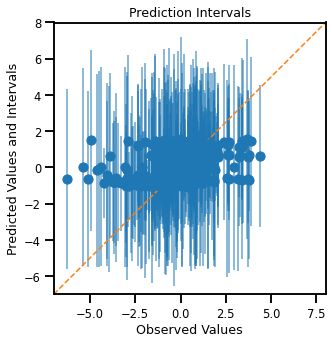

In [173]:
uviz.plot_intervals(
    y_dist.mean().ravel(), y_dist.stddev().ravel(), Y_plot.ravel(), n_subset=500,
)

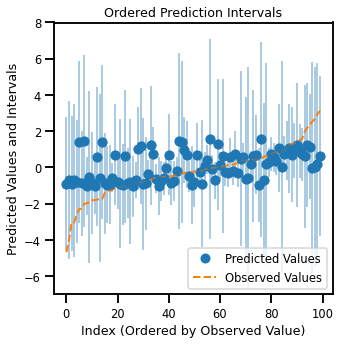

In [174]:
uviz.plot_intervals_ordered(
    y_dist.mean().ravel(), y_dist.stddev().ravel(), Y_plot.ravel(), n_subset=100
)

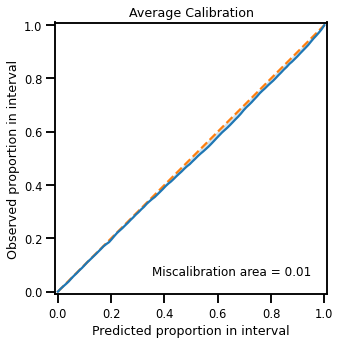

In [29]:
uviz.plot_calibration(y_dist.mean().ravel(), y_dist.stddev().ravel(), Y_plot.ravel())
plt.savefig("probnet_calib")

In [176]:
import joblib

joblib.dump(cond_model, "hetero_nn.pickle")

['hetero_nn.pickle']

In [177]:
hetero_nn = joblib.load("hetero_nn.pickle")

## Heteroscedastic Distribution

In [56]:
def f(X, seed=42):
    loc = jnp.sin(X.ravel())
    scale = jnp.exp(jnp.cos(X.ravel()))
    return np.random.normal(loc, scale)


def load_dataset(
    n_train: int,
    batch_size: int,
    seed: int,
    n_samples: int = 2_000,
    n_features: int = 2,
    noise: float = 0.05,
) -> Iterator[Batch]:
    # make random normally distributed data
    rng = np.random.RandomState(seed)
    X = jnp.linspace(0, 4 * jnp.pi, n_train)[:, None]
    y = f(X)[:, None]
    #     X, y = datasets.make_regression(
    #         n_samples=n_samples, n_features=n_features, noise=noise, random_state=seed,
    #     )
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [85]:
n_train = 1_000

ds = load_dataset(n_train, n_train, 123)

# demo batch
X_data, Y_data = next(ds)
print(X_data.shape, Y_data.shape)

(1000, 1) (1000, 1)


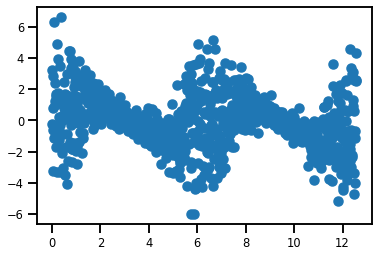

In [86]:
plt.scatter(X_data, Y_data)

In [87]:
# create model
input_features = X_data.shape[1]
# model = nn.Dense(features=input_features * 2)
model = ExplicitMLP(features=[40, 20, 10, 2])
# create dummy variable
rng, model_rng = jax.random.split(KEY, 2)
params = model.init(model_rng, X_data)

In [88]:
# initialize conditional model
cond_model = ConditionalModel(params=params, model=model)

# intialize optimizer state
opt_state = optimizer.init(cond_model)

In [89]:
train_ds = load_dataset(n_train, n_train, 123)
valid_ds = load_dataset(n_train, n_train, 123 + 100)


metrics = {
    "train_step": list(),
    "train_loss": list(),
    "valid_step": list(),
    "valid_loss": list(),
}


eval_loss = 0.0

In [90]:
with tqdm.trange(n_epochs) as pbar:
    for step in pbar:
        cond_model, opt_state, loss = update(cond_model, opt_state, next(ds))

        pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
        #         wandb.log({"train_loss": float(loss), "training_step": step})
        metrics["train_step"].append(step)
        metrics["train_loss"].append(loss)

        if step % eval_frequency == 0:
            eval_loss = eval_fn(cond_model, next(ds))

            pbar.set_description(
                f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )
            #             wandb.log({"validation_loss": float(eval_loss), "training_step": step})
            metrics["valid_step"].append(step)
            metrics["valid_loss"].append(eval_loss)

Train Loss: 1.8577 | Valid Loss: 1.8577: 100%|██████████| 5000/5000 [00:19<00:00, 254.40it/s]            


In [91]:
n_plot_samples = 1_000
rng = np.random.RandomState(42)
# X_plot = np.sort(rng.randn(n_plot_samples, 1))
X_plot = np.linspace(0, 4 * jnp.pi, n_plot_samples)[:, None]

In [92]:
y_dist = cond_model.forward(X_plot)

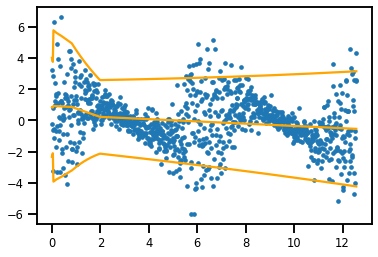

In [93]:
fig, ax = plt.subplots()
plt.plot(X_plot, y_dist.mean(), color="orange")
plt.plot(X_plot, y_dist.mean() + 1.96 * y_dist.stddev(), color="orange")
plt.plot(X_plot, y_dist.mean() - 1.96 * y_dist.stddev(), color="orange")
ax.scatter(X_data, Y_data, s=10)
plt.show()

In [257]:
from distrax._src.distributions.categorical import Categorical
from distrax._src.distributions.mixture_same_family import MixtureSameFamily
from distrax._src.distributions.bernoulli import Bernoulli
from distrax._src.distributions.uniform import Uniform

tfd = tfp.distributions
logits = jnp.array([0.33, 0.33, 0.33])
probs = jax.nn.softmax(logits, axis=-1)
x_cat_dist = Categorical(probs=probs)
norm_dist = Normal(loc=[-4.0, 0.0, 4.0], scale=[0.4, 0.6, 0.4])

mix_dist = MixtureSameFamily(x_cat_dist, norm_dist)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [297]:
n_samples = 1_000

X_samples = mix_dist.sample(seed=123, sample_shape=(n_samples,))

NameError: name 'mix_dist' is not defined

In [ ]:
fig, ax = plt.subplots()

ax.hist(X_samples, bins=100, density=True)

plt.show()

In [375]:
y = X_samples ** 3

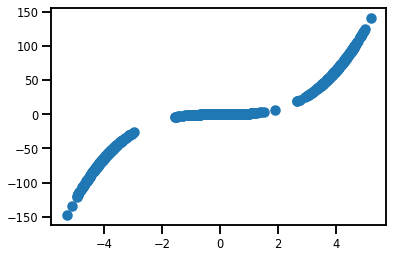

In [376]:
plt.scatter(X_samples, y)

In [368]:
noise_norm_1 = Normal(0, 3)
noise_cat_dist_2 = Uniform(low=-2.0, high=2.0)
noise_norm_2 = Normal(0, 20)


noise = noise_cat_dist_1.sample(seed=42, sample_shape=(n_samples,))
y = X_samples ** 3
# outskirts
noise_samples = noise_norm_1.sample(seed=42, sample_shape=(n_samples,))
print(noise_samples.min(), noise_samples.max())
y += 2 * noise_samples
# Middle
noise_samples = noise_norm_2.sample(seed=42, sample_shape=(n_samples,))
y += noise_cat_dist_2.prob(X_samples) * 5 * noise_samples

-9.671867 9.700486


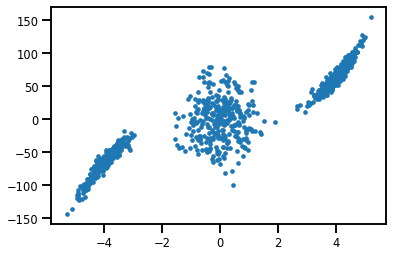

In [369]:
plt.scatter(X_samples, y, s=10)